In [11]:
import os
for dirname, _, filenames in os.walk(r'D:\Diseases Symptoms Prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

D:\Diseases Symptoms Prediction\dataset.csv
D:\Diseases Symptoms Prediction\Symptom-severity.csv
D:\Diseases Symptoms Prediction\symptom_Description.csv
D:\Diseases Symptoms Prediction\symptom_precaution.csv


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [30]:
# Laod uploaded files
df = 'D:\Diseases Symptoms Prediction\dataset.csv'
df = pd.read_csv(df)

In [34]:
# inspect the data 
df_info = {
    'shape': df.shape,
    'columns': df.columns.tolist(),
    'n_missing': df.isnull().sum().sum()
}
df_head = df.head().style.background_gradient(cmap="viridis")

display(df_info, df_head)

{'shape': (4920, 18),
 'columns': ['Disease',
  'Symptom_1',
  'Symptom_2',
  'Symptom_3',
  'Symptom_4',
  'Symptom_5',
  'Symptom_6',
  'Symptom_7',
  'Symptom_8',
  'Symptom_9',
  'Symptom_10',
  'Symptom_11',
  'Symptom_12',
  'Symptom_13',
  'Symptom_14',
  'Symptom_15',
  'Symptom_16',
  'Symptom_17'],
 'n_missing': 46992}

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,Fungal infection,itching,skin_rash,dischromic _patches,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [35]:
# Building a vocabulary foir all unique symptoms (ignoring nan)
symptom_column = [col for col in df.columns if col.startswith("Symptom_")]
all_symptoms = pd.unique(df[symptom_column].values.ravel())
all_symptoms = [s for s in all_symptoms if isinstance(s, str)] 

In [36]:
# Creating a mapping for symptoms
symptom_to_idx = {symptom: idx for  idx, symptom in enumerate(sorted(set(all_symptoms)))}

In [37]:
import numpy as np

In [40]:
# Encode dataset into multi-hot vector
X = np.zeros((len(df), len(symptom_to_idx)), dtype=int)

for i, row in df.iterrows():
    for col in symptom_column:
        symptom = row[col]
        if isinstance(symptom, str):
            X[i, symptom_to_idx[symptom]] = i

In [42]:
# Target Varible
y = df['Disease']

In [45]:
X_df = pd.DataFrame(X, columns=symptom_to_idx.keys())
preview_encoded = X_df.head().style.background_gradient(cmap='viridis')
preview_target = y.head()

display(X.shape, len(symptom_to_idx), preview_encoded, preview_target.unique()[:10])

(4920, 131)

131

,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,blister,blood_in_sputum,bloody_stool,blurred_and_distorted_vision,breathlessness,brittle_nails,bruising,burning_micturition,chest_pain,chills,cold_hands_and_feets,coma,congestion,constipation,continuous_feel_of_urine,continuous_sneezing,cough,cramps,dark_urine,dehydration,depression,diarrhoea,dischromic _patches,distention_of_abdomen,dizziness,drying_and_tingling_lips,enlarged_thyroid,excessive_hunger,extra_marital_contacts,family_history,fast_heart_rate,fatigue,fluid_overload,foul_smell_of urine,headache,high_fever,hip_joint_pain,history_of_alcohol_consumption,increased_appetite,indigestion,inflammatory_nails,internal_itching,irregular_sugar_level,irritability,irritation_in_anus,joint_pain,knee_pain,lack_of_concentration,lethargy,loss_of_appetite,loss_of_balance,loss_of_smell,malaise,mild_fever,mood_swings,movement_stiffness,mucoid_sputum,muscle_pain,muscle_wasting,muscle_weakness,nausea,neck_pain,nodal_skin_eruptions,obesity,pain_behind_the_eyes,pain_during_bowel_movements,pain_in_anal_region,painful_walking,palpitations,passage_of_gases,patches_in_throat,phlegm,polyuria,prominent_veins_on_calf,puffy_face_and_eyes,pus_filled_pimples,receiving_blood_transfusion,receiving_unsterile_injections,red_sore_around_nose,red_spots_over_body,redness_of_eyes,restlessness,runny_nose,rusty_sputum,scurring,shivering,silver_like_dusting,sinus_pressure,skin_peeling,skin_rash,slurred_speech,small_dents_in_nails,spinning_movements,spotting_ urination,stiff_neck,stomach_bleeding,stomach_pain,sunken_eyes,sweating,swelled_lymph_nodes,swelling_joints,swelling_of_stomach,swollen_blood_vessels,swollen_extremeties,swollen_legs,throat_irritation,toxic_look_(typhos),ulcers_on_tongue,unsteadiness,visual_disturbances,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


array(['Fungal infection'], dtype=object)

In [50]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression

In [52]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=42, random_state=42)

In [53]:
from sklearn.naive_bayes import MultinomialNB

In [54]:
scaler = StandardScaler()

In [55]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial'),
    "Pipeline": Pipeline([('scaler', scaler), ('clf', SVC(probability=True, random_state=42))]),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "Naive Bayes": MultinomialNB()    
}

In [56]:
# Train the evaluate each model
result = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    result[name] = acc

In [59]:
# voting Ensemble with the models
voting = VotingClassifier(estimators=[
    ('rf', models['Random Forest']),
    ('et', models['Extra Trees']),
    ('lr', models['Logistic Regression']),
    ('ab', models['AdaBoost']),
    ('nb', models['Naive Bayes']),
    ('gb', models['Gradient Boosting']),
    ('p', models['Pipeline'])   
], voting='hard')
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
result['Voting Ensemble'] = accuracy_score(y_test, y_pred)

In [60]:
# Stacking Classifier
stacking = StackingClassifier(estimators=[
    ('rf', models['Random Forest']),
    ('et', models['Extra Trees']),
    ('ab', models['AdaBoost']),
    ('nb', models['Naive Bayes']),
    ('gb', models['Gradient Boosting']),
    ('p', models['Pipeline']) 
], final_estimator=LogisticRegression(max_iter=500))
stacking.fit(X_train, y_train)
y_pred_stacking = stacking.predict(X_test)
result["Stacking Ensemble"] = accuracy_score(y_test, y_pred_stacking)

In [61]:
result

{'Logistic Regression': 1.0,
 'Pipeline': 0.9523809523809523,
 'Random Forest': 1.0,
 'Extra Trees': 1.0,
 'Gradient Boosting': 1.0,
 'AdaBoost': 0.2857142857142857,
 'Naive Bayes': 1.0,
 'Voting Ensemble': 1.0,
 'Stacking Ensemble': 1.0}

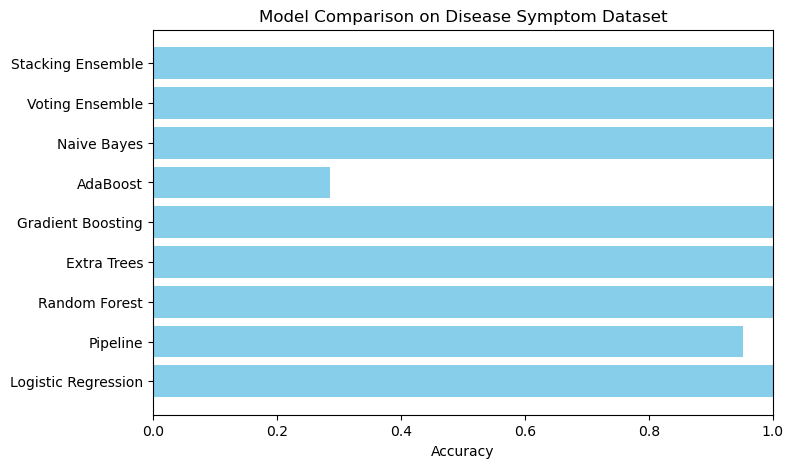

In [62]:
plt.figure(figsize=(8, 5))
plt.barh(list(result.keys()), list(result.values()), color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison on Disease Symptom Dataset")
plt.xlim(0, 1)
plt.show()